# GRU from scratch in pytorch

## Archiecture

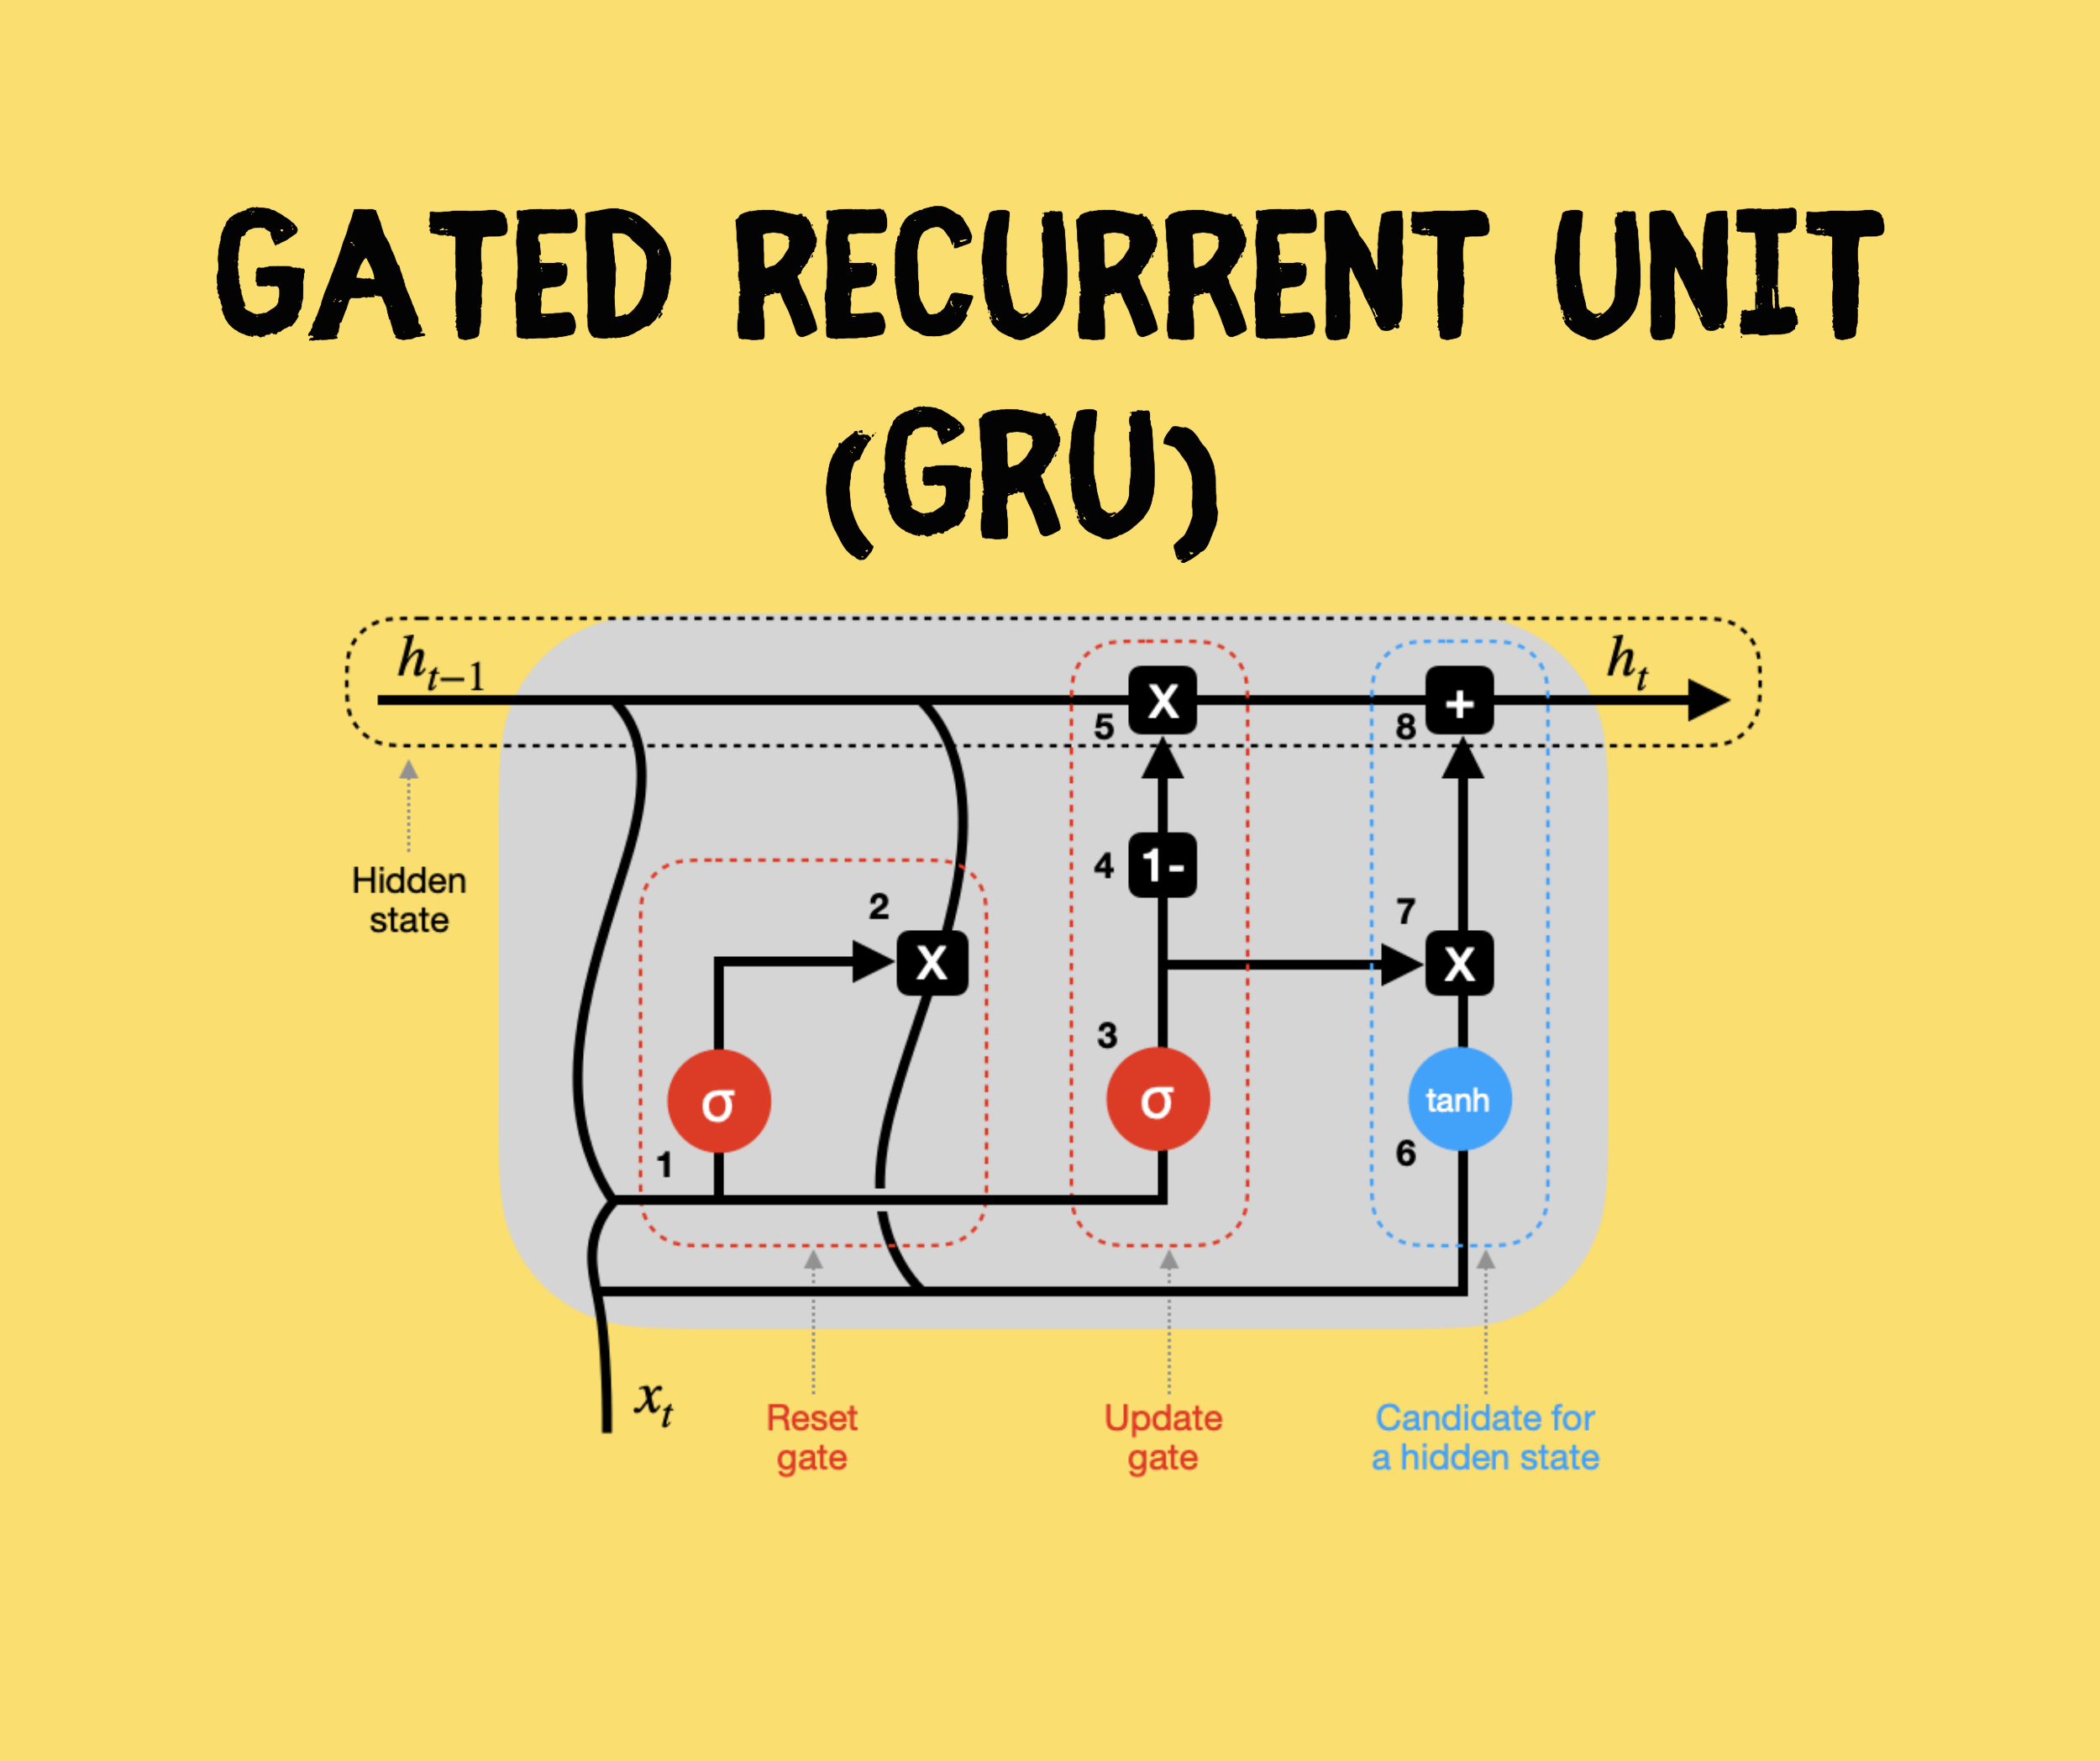

## setup

In [1]:
import torch
import matplotlib.pyplot as plt

from dataclasses import dataclass


In [2]:
def set_seed(seed:int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [3]:
@dataclass
class ModelArgs():
    epochs = 500
    max_lr = 1e-4
    no_of_neurons = 64
    ht_size = no_of_neurons
    batch_size = 32
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    embedding_dim = 32
    
    

In [4]:
num_samples = 10000
seq_length = 32

t = torch.linspace(start=0,end=100,steps=num_samples+seq_length)
data = torch.sin(t)
data += torch.rand_like(t)

X_tensor = torch.stack([data[i:i+seq_length] for i in range(num_samples)])
y_tensor = data[seq_length:]

X_tensor.shape , y_tensor.shape

(torch.Size([10000, 32]), torch.Size([10000]))

In [5]:
train_size = int(0.8 * num_samples)

X_train,y_train = X_tensor[:train_size],y_tensor[:train_size]
X_test,y_test = X_tensor[train_size:],y_tensor[train_size:]

X_train.shape,y_train.shape,X_test.shape,y_test.shape

(torch.Size([8000, 32]),
 torch.Size([8000]),
 torch.Size([2000, 32]),
 torch.Size([2000]))

In [6]:
from torch.utils.data import Dataset , DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self,X,y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index],self.y[index]
    

train_dataset = TimeSeriesDataset(X_train,y_train)
val_dataset = TimeSeriesDataset(X_test,y_test)

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=ModelArgs.batch_size,
                              shuffle=True)

val_dataloader = DataLoader(dataset=val_dataset,
                              batch_size=ModelArgs.batch_size,
                              shuffle=True,
                              drop_last=True)

### Reset Gate

```python
r_t = sigma(Wr[ht,Xt]+br)
```

In [7]:
import torch.nn as nn
class ResetGate(nn.Module):
    def __init__(self,h_t_size,embedding_dim):
        super(ResetGate,self).__init__()
        
        self.sigma_nn = nn.Sequential(
            nn.Linear(in_features=h_t_size+embedding_dim,out_features=h_t_size),
            nn.Sigmoid()
        )
    def forward(self,h_t,X_t):
        # print(h_t.shape)
        # print(X_t.shape)
        combined = torch.cat([h_t,X_t],dim=1)
        # print(combined.shape)
        r_t = self.sigma_nn(combined)
        
        return r_t

### Output Gate

```python
z_t = sigma(wz[ht,xt]+bz)
```

In [8]:
class UpdateGate(nn.Module):
    def __init__(self,h_t_size,embedding_dim):
        super(UpdateGate,self).__init__()
        
        self.sigma_nn = nn.Sequential(
            nn.Linear(in_features=h_t_size+embedding_dim,out_features=h_t_size),
            nn.Sigmoid()
        )
    def forward(self,h_t,X_t):
        combined = torch.cat([h_t,X_t],dim=1)
        
        z_t = self.sigma_nn(combined)
        
        return z_t

### GRU cell

In [9]:
class GRUCell(nn.Module):
    def __init__(self,h_t_size,embedding_dim):
        super(GRUCell,self).__init__()
        
        self.tanh_nn = nn.Sequential(
            nn.Linear(in_features=h_t_size+embedding_dim,out_features=h_t_size),
            nn.Tanh()
        )
        
        self.reset_gate = ResetGate(h_t_size=h_t_size,embedding_dim=embedding_dim)
        
        self.update_gate = UpdateGate(h_t_size=h_t_size,embedding_dim=embedding_dim)
    
    def forward(self,h_t,X_t):
        
        r_t = self.reset_gate(h_t,X_t)
        
        modulated_hidden_state = h_t * r_t
        
        modulated_hidden_state_X_t = torch.cat([modulated_hidden_state,X_t],dim=1)
        
        candidate_hidden_state = self.tanh_nn(modulated_hidden_state_X_t)
        
        z_t = self.update_gate(h_t,X_t)
        
        h_t_f = ((1-z_t) * h_t) + (z_t * candidate_hidden_state) 
        
        return h_t_f
        
        

In [10]:
class GRUModel(nn.Module):
    def __init__(self,h_t_size,embedding_dim):
        super(GRUModel,self).__init__()
        
        self.embedding_layer = nn.Linear(in_features=1,out_features=embedding_dim)
        self.gru_cell = GRUCell(h_t_size=h_t_size,embedding_dim=embedding_dim)
        self.head = nn.Linear(in_features=h_t_size,out_features=1) # since regression task
        
    def forward(self,X_t,h_t=None):
        if h_t == None:
            h_t = torch.zeros(size=[ModelArgs.batch_size,ModelArgs.ht_size],device=ModelArgs.device)
        
        for i in range(X_t.shape[-1]):
            embedding_i = self.embedding_layer(X_t[:,i].unsqueeze(1)) # batch_size , 1
            
            # print("eb")
            # print(embedding_i.device)
            # print("ht")
            # print(h_t.device)
            h_t = self.gru_cell(h_t,embedding_i) # a single 
        
        pred = self.head(h_t)
        return pred
        

In [11]:
sample_batch = next(iter(train_dataloader))

sample_batch

[tensor([[ 0.5248,  0.6065,  0.7628,  ...,  0.3045,  1.1171,  1.0561],
         [ 0.8011,  0.6323,  0.1054,  ...,  0.3271,  0.0998,  0.0500],
         [ 0.8967,  1.4962,  1.5879,  ...,  0.8197,  1.3306,  0.5668],
         ...,
         [ 1.4479,  1.4356,  1.6082,  ...,  1.2135,  1.3867,  1.8930],
         [ 0.5220,  0.2254, -0.0046,  ..., -0.1818, -0.0544,  0.4713],
         [-0.5476,  0.1813, -0.3740,  ...,  0.0532, -0.8132, -0.1829]]),
 tensor([ 1.0447,  0.3819,  0.8800, -0.7127,  1.3307, -0.1270,  0.5125, -0.0366,
         -0.3536,  1.1462,  1.3498,  1.3996, -0.5326,  0.2478,  1.0033,  1.1181,
          1.1809, -0.0409,  0.8967,  1.2486, -0.0902,  1.1917, -0.3988, -0.6288,
         -0.7440, -0.3282, -0.0901, -0.4582,  1.0110,  1.1081,  0.2578, -0.8563])]

In [12]:
sample_batch[0].shape,sample_batch[1].shape

(torch.Size([32, 32]), torch.Size([32]))

In [13]:
set_seed()
gru = GRUModel(h_t_size=ModelArgs.ht_size,embedding_dim=ModelArgs.embedding_dim)

gru = gru.to(ModelArgs.device)

In [14]:
gru(sample_batch[0].to(ModelArgs.device))



tensor([[ 0.0078],
        [-0.0091],
        [ 0.0022],
        [-0.0434],
        [ 0.0043],
        [-0.0027],
        [ 0.0069],
        [-0.0036],
        [-0.0389],
        [ 0.0115],
        [ 0.0094],
        [ 0.0106],
        [-0.0229],
        [-0.0221],
        [-0.0014],
        [ 0.0084],
        [ 0.0123],
        [-0.0155],
        [ 0.0096],
        [ 0.0088],
        [-0.0352],
        [ 0.0098],
        [-0.0162],
        [-0.0184],
        [-0.0446],
        [-0.0054],
        [-0.0018],
        [-0.0166],
        [ 0.0072],
        [ 0.0123],
        [-0.0063],
        [-0.0239]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [15]:
def train(model,model_name,criterion,optimizer,train_dataloader,val_dataloader,num_epochs,device):
    from tqdm import tqdm
    best_val_loss = float('inf')
    min_val_loss = 1e-3
    train_losses = []
    val_losses = []
    model = model.to(device)
    for i in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_progress = tqdm(train_dataloader,desc="Training")
        
        for batch in train_progress:
            X = batch[0].to(device)
            y = batch[1].to(device)
            
            optimizer.zero_grad()
            pred = model(X).squeeze()
            loss = criterion(pred,y)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
             
            train_progress.set_postfix({"Train Loss" : f"{loss.item():.4f}"})
        
        train_loss /= len(train_dataloader)
            
        with torch.inference_mode():
            model.eval()
            val_loss = 0.0
            val_progress = tqdm(val_dataloader,desc="Evaluation")
            for batch in val_progress:
                X = batch[0].to(device)
                y = batch[1].to(device)
                
                pred = model(X).squeeze()
                loss = criterion(pred,y)
                
                val_loss += loss.item()
                
                val_progress.set_postfix({"Val Loss":f"{loss.item()}"})
            
            val_loss /= len(val_dataloader)
            
        print(f"Epoch : {i+1}/{num_epochs}\n Train Loss : {train_loss} \n Val Loss : {val_loss} \n")
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        
        if best_val_loss > val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(),model_name)
            
        if val_loss < min_val_loss:
            print("[SUCCESS] model trained successfully")
            break
    
    return train_losses,val_losses
            
            
            
            
            
            

In [16]:
from torchinfo import summary

summary(model=gru.to(ModelArgs.device),
        input_size=[32,32],
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"],
        device=ModelArgs.device)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
GRUModel (GRUModel)                      [32, 32]             [32, 1]              --                   True
├─Linear (embedding_layer)               [32, 1]              [32, 32]             64                   True
├─GRUCell (gru_cell)                     [32, 64]             [32, 64]             --                   True
│    └─ResetGate (reset_gate)            [32, 64]             [32, 64]             --                   True
│    │    └─Sequential (sigma_nn)        [32, 96]             [32, 64]             6,208                True
│    └─Sequential (tanh_nn)              [32, 96]             [32, 64]             --                   True
│    │    └─Linear (0)                   [32, 96]             [32, 64]             6,208                True
│    │    └─Tanh (1)                     [32, 64]             [32, 64]             --                   --
│    └─UpdateGat

In [17]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gru.parameters(),lr=ModelArgs.max_lr)

train_loss_1,val_loss_1 = train(model=gru,
                                model_name="GRU_from_scratch.pth",
                                criterion=criterion,
                                optimizer=optimizer,
                                train_dataloader=train_dataloader,
                                val_dataloader=val_dataloader,
                                num_epochs=ModelArgs.epochs,
                                device=ModelArgs.device)

Evaluation: 100%|██████████| 62/62 [00:01<00:00, 49.10it/s, Val Loss=0.10432878881692886]


Epoch : 1/500
 Train Loss : 0.2086228275001049 
 Val Loss : 0.09635063945766419 



Evaluation: 100%|██████████| 62/62 [00:01<00:00, 47.49it/s, Val Loss=0.11532851308584213]


Epoch : 2/500
 Train Loss : 0.09466924093663692 
 Val Loss : 0.09486291281157924 



Evaluation: 100%|██████████| 62/62 [00:01<00:00, 52.99it/s, Val Loss=0.09330148994922638]


Epoch : 3/500
 Train Loss : 0.09348699687421322 
 Val Loss : 0.09444523524613149 



Evaluation: 100%|██████████| 62/62 [00:01<00:00, 52.91it/s, Val Loss=0.12635603547096252]


Epoch : 4/500
 Train Loss : 0.09301676666736602 
 Val Loss : 0.09388552660182599 



Evaluation: 100%|██████████| 62/62 [00:01<00:00, 46.94it/s, Val Loss=0.1063496470451355] 


Epoch : 5/500
 Train Loss : 0.09290644145011902 
 Val Loss : 0.09413363099578888 



Evaluation: 100%|██████████| 62/62 [00:01<00:00, 49.36it/s, Val Loss=0.05263636261224747]


Epoch : 6/500
 Train Loss : 0.09279593218863011 
 Val Loss : 0.09324084426606855 



Evaluation: 100%|██████████| 62/62 [00:01<00:00, 53.63it/s, Val Loss=0.09078003466129303]


Epoch : 7/500
 Train Loss : 0.09276586231589318 
 Val Loss : 0.09392554336978544 



Evaluation: 100%|██████████| 62/62 [00:01<00:00, 55.08it/s, Val Loss=0.09743845462799072]


Epoch : 8/500
 Train Loss : 0.0928014858365059 
 Val Loss : 0.09331519096609085 



Evaluation: 100%|██████████| 62/62 [00:01<00:00, 54.74it/s, Val Loss=0.11412574350833893]


Epoch : 9/500
 Train Loss : 0.09263509830832481 
 Val Loss : 0.09328287719718871 



Evaluation: 100%|██████████| 62/62 [00:01<00:00, 47.71it/s, Val Loss=0.12711116671562195]


Epoch : 10/500
 Train Loss : 0.0923992288261652 
 Val Loss : 0.09301026718270394 



Evaluation: 100%|██████████| 62/62 [00:02<00:00, 25.01it/s, Val Loss=0.07730264961719513]


Epoch : 11/500
 Train Loss : 0.09224312430620193 
 Val Loss : 0.09508522521824606 



Evaluation: 100%|██████████| 62/62 [00:02<00:00, 25.37it/s, Val Loss=0.09969988465309143] 


Epoch : 12/500
 Train Loss : 0.09234711058437824 
 Val Loss : 0.09569999924109827 



Evaluation: 100%|██████████| 62/62 [00:02<00:00, 24.59it/s, Val Loss=0.09330271929502487] 


Epoch : 13/500
 Train Loss : 0.09237168081104756 
 Val Loss : 0.09289270879760865 



Evaluation: 100%|██████████| 62/62 [00:02<00:00, 22.11it/s, Val Loss=0.09789588302373886] 


Epoch : 14/500
 Train Loss : 0.09278054980933666 
 Val Loss : 0.09289862065305633 



Evaluation: 100%|██████████| 62/62 [00:02<00:00, 22.82it/s, Val Loss=0.10920479148626328]


Epoch : 15/500
 Train Loss : 0.09250856816768646 
 Val Loss : 0.09301190619026461 



Evaluation: 100%|██████████| 62/62 [00:02<00:00, 22.79it/s, Val Loss=0.09619590640068054] 


Epoch : 16/500
 Train Loss : 0.09236019760370255 
 Val Loss : 0.09342090545162078 



Evaluation: 100%|██████████| 62/62 [00:01<00:00, 50.29it/s, Val Loss=0.08466427773237228] 


Epoch : 17/500
 Train Loss : 0.09226662550866604 
 Val Loss : 0.09359261393547058 



Evaluation: 100%|██████████| 62/62 [00:01<00:00, 50.85it/s, Val Loss=0.10908153653144836]


Epoch : 18/500
 Train Loss : 0.0925984137505293 
 Val Loss : 0.0935453663189565 



Evaluation: 100%|██████████| 62/62 [00:02<00:00, 21.99it/s, Val Loss=0.0834130197763443]  


Epoch : 19/500
 Train Loss : 0.09233200973272324 
 Val Loss : 0.09377325001743532 



Evaluation: 100%|██████████| 62/62 [00:02<00:00, 23.41it/s, Val Loss=0.0653938502073288] 


Epoch : 20/500
 Train Loss : 0.09247742636501789 
 Val Loss : 0.09322759677325526 



Evaluation: 100%|██████████| 62/62 [00:02<00:00, 21.86it/s, Val Loss=0.10646016895771027]


Epoch : 21/500
 Train Loss : 0.09221192169189453 
 Val Loss : 0.09276714788809899 



Evaluation: 100%|██████████| 62/62 [00:02<00:00, 24.02it/s, Val Loss=0.10630330443382263]


Epoch : 22/500
 Train Loss : 0.09249580873548985 
 Val Loss : 0.09417897991595729 



Evaluation: 100%|██████████| 62/62 [00:01<00:00, 54.47it/s, Val Loss=0.10731580853462219]


Epoch : 23/500
 Train Loss : 0.09244929502904416 
 Val Loss : 0.09317234452934034 



Evaluation: 100%|██████████| 62/62 [00:01<00:00, 43.76it/s, Val Loss=0.09609355032444]   


Epoch : 24/500
 Train Loss : 0.09235719291865825 
 Val Loss : 0.09313793882967965 



Evaluation: 100%|██████████| 62/62 [00:01<00:00, 46.52it/s, Val Loss=0.088192418217659]  


Epoch : 25/500
 Train Loss : 0.09218562522530556 
 Val Loss : 0.09297946684302823 



Evaluation: 100%|██████████| 62/62 [00:01<00:00, 51.90it/s, Val Loss=0.10970953106880188] 


Epoch : 26/500
 Train Loss : 0.0922311241030693 
 Val Loss : 0.09278921518594987 



Evaluation: 100%|██████████| 62/62 [00:01<00:00, 52.48it/s, Val Loss=0.1084570363163948] 


Epoch : 27/500
 Train Loss : 0.09211275650560856 
 Val Loss : 0.09290943961710699 



Evaluation: 100%|██████████| 62/62 [00:01<00:00, 54.26it/s, Val Loss=0.08203069120645523]


Epoch : 28/500
 Train Loss : 0.09253282180428504 
 Val Loss : 0.09347906306145652 



Evaluation: 100%|██████████| 62/62 [00:01<00:00, 59.79it/s, Val Loss=0.08905042707920074]


Epoch : 29/500
 Train Loss : 0.09208400954306126 
 Val Loss : 0.09354360185323222 



Evaluation: 100%|██████████| 62/62 [00:01<00:00, 49.32it/s, Val Loss=0.09507995843887329]


Epoch : 30/500
 Train Loss : 0.09221936252713203 
 Val Loss : 0.09295182470833102 



Evaluation: 100%|██████████| 62/62 [00:01<00:00, 40.33it/s, Val Loss=0.08727411925792694]


Epoch : 31/500
 Train Loss : 0.09196647860109806 
 Val Loss : 0.0940506259400037 



Evaluation: 100%|██████████| 62/62 [00:01<00:00, 52.19it/s, Val Loss=0.09639085829257965]


Epoch : 32/500
 Train Loss : 0.09228113102912903 
 Val Loss : 0.09244691244056148 



Evaluation: 100%|██████████| 62/62 [00:01<00:00, 44.98it/s, Val Loss=0.07682982832193375]


Epoch : 33/500
 Train Loss : 0.09188131682574749 
 Val Loss : 0.09352484603803005 



Evaluation: 100%|██████████| 62/62 [00:01<00:00, 50.96it/s, Val Loss=0.10559158027172089] 


Epoch : 34/500
 Train Loss : 0.09209693971276284 
 Val Loss : 0.0927398411496993 



Evaluation: 100%|██████████| 62/62 [00:01<00:00, 52.84it/s, Val Loss=0.09315522015094757]


Epoch : 35/500
 Train Loss : 0.09179229040443897 
 Val Loss : 0.09218712523579597 



Evaluation: 100%|██████████| 62/62 [00:01<00:00, 47.96it/s, Val Loss=0.10672280192375183] 


Epoch : 36/500
 Train Loss : 0.0918821407854557 
 Val Loss : 0.09299588660078664 



Evaluation: 100%|██████████| 62/62 [00:01<00:00, 49.24it/s, Val Loss=0.09561088681221008]


Epoch : 37/500
 Train Loss : 0.09183744125068188 
 Val Loss : 0.09340279297001901 



Evaluation: 100%|██████████| 62/62 [00:01<00:00, 50.81it/s, Val Loss=0.08245354145765305] 


Epoch : 38/500
 Train Loss : 0.09169079434871674 
 Val Loss : 0.09289903025473317 



Evaluation: 100%|██████████| 62/62 [00:02<00:00, 21.37it/s, Val Loss=0.09852877259254456]


Epoch : 39/500
 Train Loss : 0.09183199064433575 
 Val Loss : 0.09275550172934609 



Evaluation: 100%|██████████| 62/62 [00:01<00:00, 47.41it/s, Val Loss=0.07347643375396729]


Epoch : 40/500
 Train Loss : 0.09165588293969631 
 Val Loss : 0.09293032365460549 



Evaluation: 100%|██████████| 62/62 [00:01<00:00, 50.82it/s, Val Loss=0.10080592334270477] 


Epoch : 41/500
 Train Loss : 0.09163938584923745 
 Val Loss : 0.09266382401749011 



Evaluation: 100%|██████████| 62/62 [00:02<00:00, 22.41it/s, Val Loss=0.09513376653194427] 


Epoch : 42/500
 Train Loss : 0.09153339482843875 
 Val Loss : 0.09243202714189407 



Evaluation: 100%|██████████| 62/62 [00:02<00:00, 23.57it/s, Val Loss=0.08674199879169464]


Epoch : 43/500
 Train Loss : 0.09144098980724812 
 Val Loss : 0.09233433705183768 



Evaluation: 100%|██████████| 62/62 [00:02<00:00, 23.63it/s, Val Loss=0.06249655783176422]


Epoch : 44/500
 Train Loss : 0.09161802265048027 
 Val Loss : 0.09201841933592673 



Evaluation: 100%|██████████| 62/62 [00:02<00:00, 20.85it/s, Val Loss=0.07952414453029633]


Epoch : 45/500
 Train Loss : 0.0913675543218851 
 Val Loss : 0.09196197686176147 



Evaluation: 100%|██████████| 62/62 [00:01<00:00, 38.36it/s, Val Loss=0.08304895460605621]


Epoch : 46/500
 Train Loss : 0.09141911952197551 
 Val Loss : 0.09256968803463443 



Evaluation: 100%|██████████| 62/62 [00:01<00:00, 45.76it/s, Val Loss=0.11438442766666412] 


Epoch : 47/500
 Train Loss : 0.09138484400510788 
 Val Loss : 0.0923458828080085 



Evaluation: 100%|██████████| 62/62 [00:01<00:00, 49.12it/s, Val Loss=0.08200196176767349]


Epoch : 48/500
 Train Loss : 0.09129776245355606 
 Val Loss : 0.09224594636790213 



Evaluation: 100%|██████████| 62/62 [00:01<00:00, 48.52it/s, Val Loss=0.08987639844417572]


Epoch : 49/500
 Train Loss : 0.0912462552934885 
 Val Loss : 0.09199713585117171 



Evaluation: 100%|██████████| 62/62 [00:01<00:00, 47.76it/s, Val Loss=0.09850329160690308] 


Epoch : 50/500
 Train Loss : 0.09116977973282338 
 Val Loss : 0.09241962234579748 



Evaluation: 100%|██████████| 62/62 [00:01<00:00, 45.28it/s, Val Loss=0.0779847651720047] 


Epoch : 51/500
 Train Loss : 0.0913427889496088 
 Val Loss : 0.09275617162066122 



Evaluation: 100%|██████████| 62/62 [00:01<00:00, 52.12it/s, Val Loss=0.09278997778892517]


Epoch : 52/500
 Train Loss : 0.09120128574967384 
 Val Loss : 0.09212677703509407 



Evaluation: 100%|██████████| 62/62 [00:01<00:00, 45.57it/s, Val Loss=0.1253630816936493] 


Epoch : 53/500
 Train Loss : 0.09132499645650387 
 Val Loss : 0.09211427237718336 



Evaluation: 100%|██████████| 62/62 [00:01<00:00, 43.29it/s, Val Loss=0.07905317097902298]


Epoch : 54/500
 Train Loss : 0.09123446902632713 
 Val Loss : 0.09252455746454577 



Training:  25%|██▌       | 63/250 [00:03<00:11, 16.22it/s, Train Loss=0.1090]


KeyboardInterrupt: 

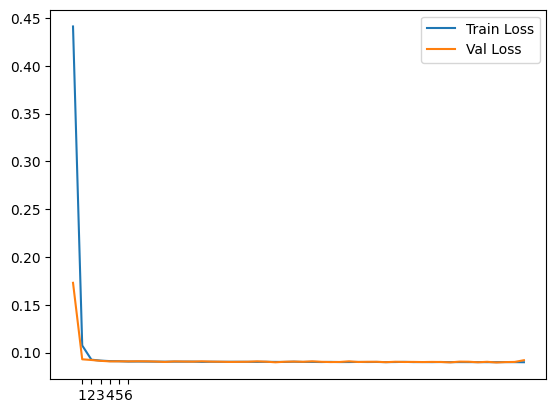

In [ ]:
plt.plot(train_loss_1,label="Train Loss")
plt.plot(val_loss_1,label="Val Loss")
plt.xticks([i for i in range(1,7)])
plt.legend()